# Descision Tree
`05_descision_tree.ipynb`

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

wine = pd.read_csv('./wine.csv')
wine.head()
wine.info()
wine.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   alcohol  6497 non-null   float64
 1   sugar    6497 non-null   float64
 2   pH       6497 non-null   float64
 3   class    6497 non-null   float64
dtypes: float64(4)
memory usage: 203.2 KB


,alcohol,sugar,pH,class
count,6497.000000,6497.000000,6497.000000,6497.000000
mean,10.491801,5.443235,3.218501,0.753886
std,1.192712,4.757804,0.160787,0.430779
min,8.000000,0.600000,2.720000,0.000000
25%,9.500000,1.800000,3.110000,1.000000
50%,10.300000,3.000000,3.210000,1.000000
75%,11.300000,8.100000,3.320000,1.000000
max,14.900000,65.800000,4.010000,1.000000


In [8]:
from sklearn.model_selection import train_test_split

# 데이터 분리
X = wine[['alcohol', 'sugar', 'pH']].to_numpy()
y = wine['class'].to_numpy()

# 훈련:테스트 = 8:2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape

((5197, 3), (1300, 3))

In [9]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

In [13]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train_scaled, y_train)

print('훈련점수: ', lr.score(X_train_scaled, y_train))
print('테스트점수: ', lr.score(X_test_scaled, y_test))

print(lr.classes_)
lr.predict_proba(X_test_scaled[:5])

print(lr.coef_, lr.intercept_)

훈련점수:  0.7808350971714451
테스트점수:  0.7776923076923077
[0. 1.]
[[ 0.51268071  1.67335441 -0.68775646]] [1.81773456]


In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_scaled, y_train)

print('훈련점수: ', dt.score(X_train_scaled, y_train))
print('테스트점수: ', dt.score(X_test_scaled, y_test))

훈련점수:  0.996921300750433
테스트점수:  0.8592307692307692
3939


0.3669367279393918


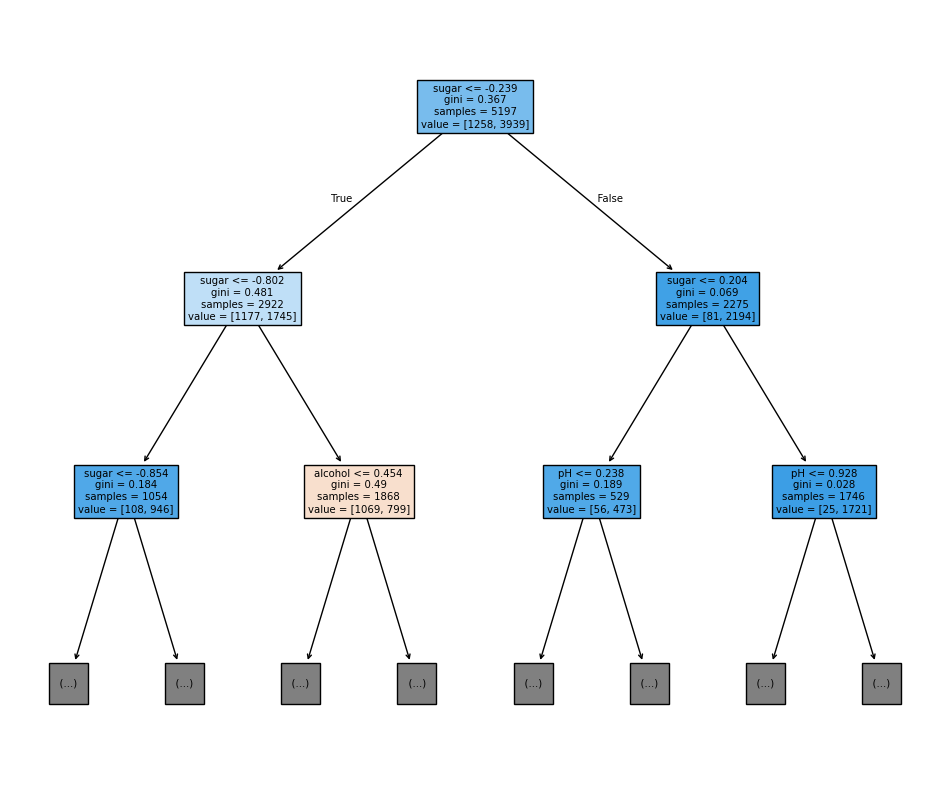

In [26]:
from sklearn.tree import plot_tree

# 지니불순도 1 - (음성클래스비율^2 + 양성클래스비율^2)
gini = 1 - ( (1258/5197)**2 + (3939/5197)**2)
print(gini)

plt.figure(figsize=(12,10))
plot_tree(dt, max_depth=2, filled=True, feature_names=['alcohol', 'sugar', 'pH'])
plt.show()

훈련점수:  0.8672310948624207
테스트점수:  0.8607692307692307


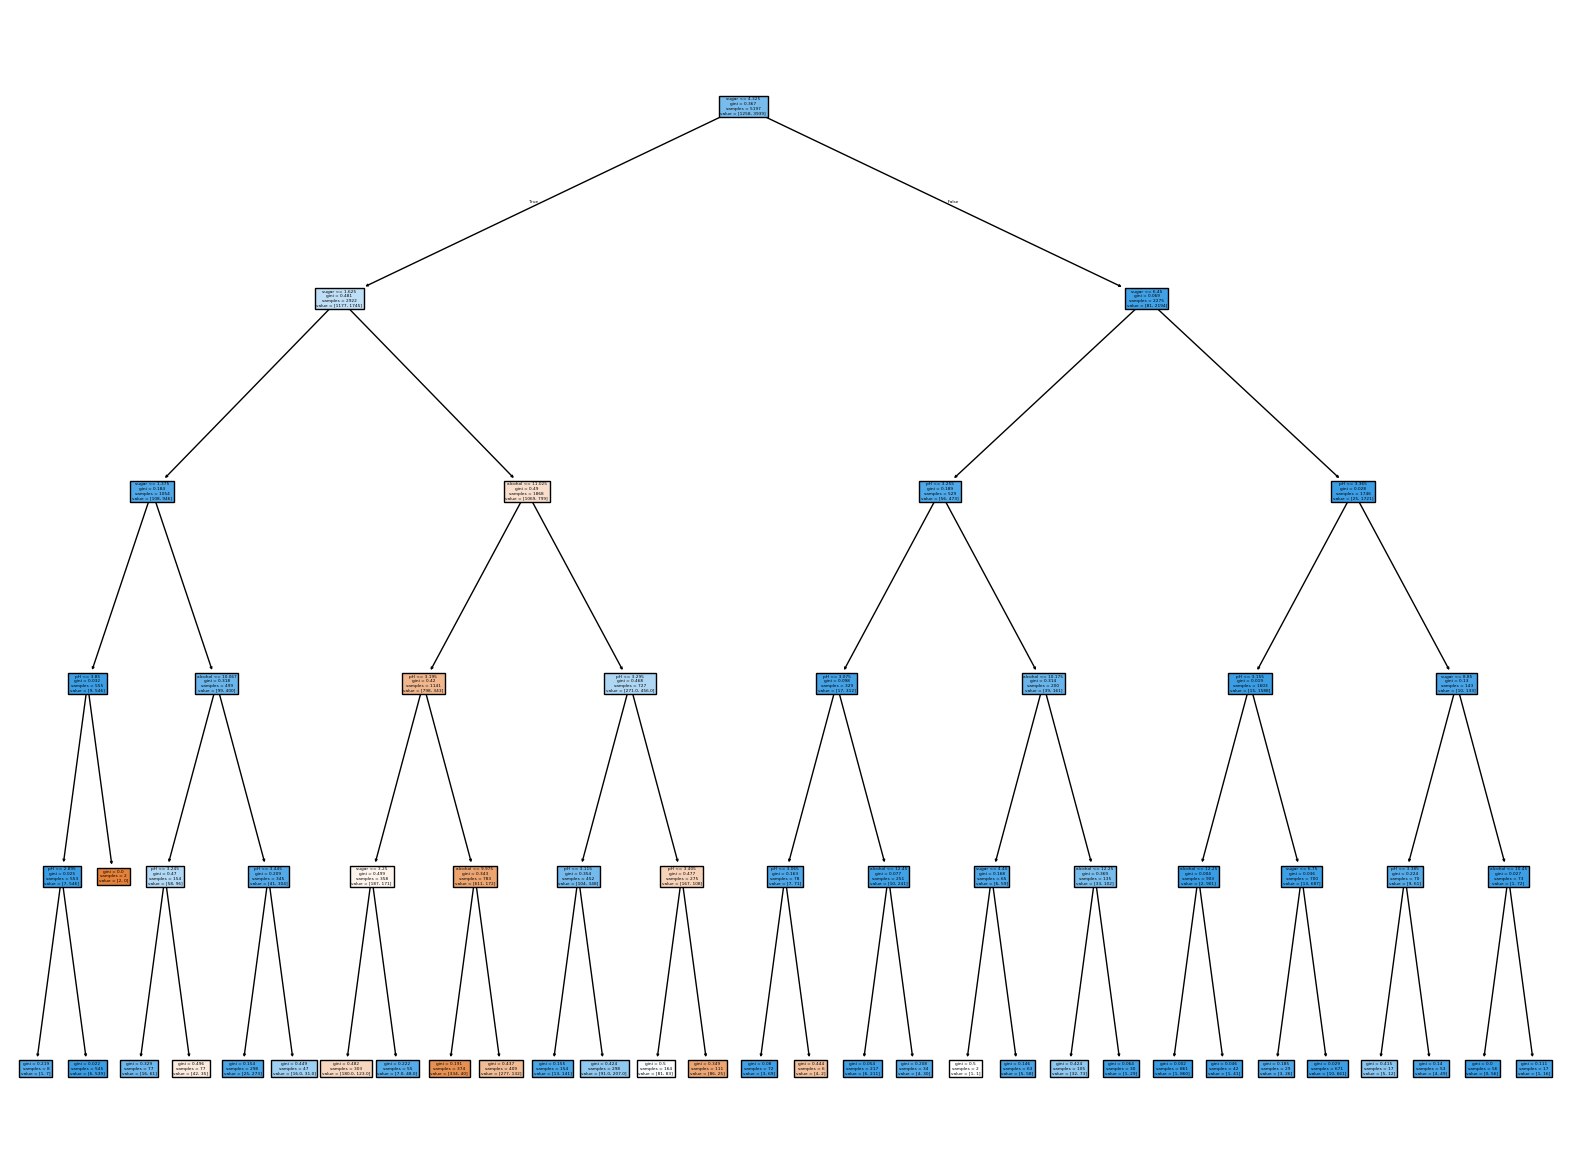

In [41]:
dt = DecisionTreeClassifier(max_depth=5, random_state=42)
dt.fit(X_train, y_train)
print('훈련점수: ', dt.score(X_train, y_train))
print('테스트점수: ', dt.score(X_test, y_test))

plt.figure(figsize=(20, 15))
plot_tree(dt, filled=True, feature_names=['alcohol', 'sugar', 'pH'])
plt.show()
